<a href="https://colab.research.google.com/github/karthikmohan1702/EVA6/blob/main/S7_Advanced_concepts/S7_Dilated_Depthwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pytorch related imports
# -----------------------
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, OneCycleLR
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Python related imports
# -----------------------
from __future__ import print_function
from tqdm import tqdm
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
# Google drive
# ------------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install torchsummary
# !pip install -U albumentations

In [4]:
# Local imports
# -------------
sys.path.append("/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/")
sys.path.append("/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/model/")
from dataloader import load_data, augmentations
from cifar10_model import cifar10_Net
from model import train, test
from utils import misc, visualization

## Data Analysis

In [5]:
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_set = CIFAR10(root="data/", transform=transforms.ToTensor(), download=True)
test_set = CIFAR10(root='data/', train=False, transform=transforms.ToTensor(), download=True)
train_loader, test_loader = load_data.train_test_loader(train_set, test_set, batch_size)


Files already downloaded and verified
Files already downloaded and verified


**View the Images that are present in the dataset**

Classes present in the dataset ==>  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


    dog    ship airplane     cat    bird


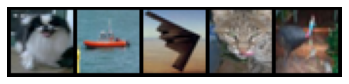

In [6]:
sample_data_loader, _ = load_data.train_test_loader(train_set, test_set, batch_size=5)
classes = train_set.classes
print("Classes present in the dataset ==> ", classes)
print("\n")

# Grid of images, tagged with its label
visualization.plot_sample_img(sample_data_loader, classes)

**Size of Train & Test Dataset**


In [7]:
print("Train dataset size")
print("==="*6)
print(train_set)
print("\n")
print("Test dataset size")
print("==="*6)
print(test_set)

Train dataset size
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


Test dataset size
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()


**Mean & std deviation**

In [8]:
mean, std = misc.get_mean_std(train_loader)
print("\n\n","mean ==> ", mean, "\n","std ==> ", std)

100%|██████████| 391/391 [00:05<00:00, 72.23it/s]



 mean ==>  tensor([0.4914, 0.4821, 0.4465]) 
 std ==>  tensor([0.2470, 0.2435, 0.2616])


**Checking distribution of classes in Train & Test dataset**

In [9]:
misc.print_dist_stats(train_set, test_set)

Distribution of classes in Train Dataset


Counter({'airplane': 5000,
         'automobile': 5000,
         'bird': 5000,
         'cat': 5000,
         'deer': 5000,
         'dog': 5000,
         'frog': 5000,
         'horse': 5000,
         'ship': 5000,
         'truck': 5000})



Distribution of classes in Test Dataset


Counter({'airplane': 1000,
         'automobile': 1000,
         'bird': 1000,
         'cat': 1000,
         'deer': 1000,
         'dog': 1000,
         'frog': 1000,
         'horse': 1000,
         'ship': 1000,
         'truck': 1000})



Distribution of size of image in Train Dataset


Counter({(3, 32, 32): 50000})



Distribution of size of image in Test Dataset


Counter({(3, 32, 32): 10000})

### Downloading Dataset, dataloader & Albumentations

In [10]:
mean.tolist(), std.tolist()

([0.49138519167900085, 0.4821462035179138, 0.44650936126708984],
 [0.2470356971025467, 0.24348768591880798, 0.26158225536346436])

**Albumentations**

In [11]:
train_transform, test_transform = augmentations.albumentaion_transform(mean.tolist(), std.tolist())

**Data Loader**

In [12]:
trainset= load_data.get_cifar10_dataset(transform=train_transform)
testset= load_data.get_cifar10_dataset(train= False, transform= test_transform)
batch_size = 128

train_loader, test_loader = load_data.train_test_loader(trainset, testset, batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
print("Train set")
print("=="*6)
trainset

Train set


Dataset get_cifar10_dataset
    Number of datapoints: 50000
    Root location: /root/data/cifar10
    Split: Train
    StandardTransform
Transform: Compose([
             HorizontalFlip(always_apply=False, p=0.2),
             ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None),
             CoarseDropout(always_apply=False, p=0.5, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=1, fill_value=[0.49138519167900085, 0.4821462035179138, 0.44650936126708984], mask_fill_value=None),
             Normalize(always_apply=False, p=1.0, mean=[0.49138519167900085, 0.4821462035179138, 0.44650936126708984], std=[0.2470356971025467, 0.24348768591880798, 0.26158225536346436], max_pixel_value=255.0),
             ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
 

In [14]:
print("Test set")
print("=="*6)
testset

Test set


Dataset get_cifar10_dataset
    Number of datapoints: 10000
    Root location: /root/data/cifar10
    Split: Test
    StandardTransform
Transform: Compose([
             Normalize(always_apply=False, p=1.0, mean=[0.49138519167900085, 0.4821462035179138, 0.44650936126708984], std=[0.2470356971025467, 0.24348768591880798, 0.26158225536346436], max_pixel_value=255.0),
             ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
           ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

## Summary of the model

In [15]:
misc.get_model_summary(model=cifar10_Net(), input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           1,056
           Conv2d-10           [-1, 32, 14, 14]           9,248
           Conv2d-11           [-1, 64, 12, 12]          18,496
      BatchNorm2d-12           [-1, 64, 12, 12]             128
             ReLU-13           [-1, 64, 12, 12]               0
          Dropout-14           [-1

/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/model/cifar10_model.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [16]:
cifar10_Net().eval

<bound method Module.eval of cifar10_Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.06, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.06, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), dilation=(2, 2))
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.06, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [17]:
device = misc.get_device_info()
print("Device in use ==> ", device)

cuda
Device in use ==>  cuda


## Model Training

In [18]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

EPOCHS = 100

device = misc.get_device_info()

model =  cifar10_Net(dropout_value=0.04).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = OneCycleLR(optimizer, max_lr=0.05, epochs=EPOCHS, steps_per_epoch=len(train_loader))

model.eval()
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train.set_train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test.set_test(model, device, test_loader, test_acc, test_losses)

  0%|          | 0/391 [00:00<?, ?it/s]

cuda
EPOCH: 0


/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/model/cifar10_model.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=1.470875859260559 Batch_id=390 Accuracy=35.43: 100%|██████████| 391/391 [00:11<00:00, 32.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 4811/10000 (48.11%)

EPOCH: 1


Loss=1.524038314819336 Batch_id=390 Accuracy=48.55: 100%|██████████| 391/391 [00:11<00:00, 32.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 5683/10000 (56.83%)

EPOCH: 2


Loss=1.3654601573944092 Batch_id=390 Accuracy=54.35: 100%|██████████| 391/391 [00:12<00:00, 32.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 6147/10000 (61.47%)

EPOCH: 3


Loss=0.9711434245109558 Batch_id=390 Accuracy=58.54: 100%|██████████| 391/391 [00:12<00:00, 32.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 6467/10000 (64.67%)

EPOCH: 4


Loss=1.1588375568389893 Batch_id=390 Accuracy=61.91: 100%|██████████| 391/391 [00:12<00:00, 32.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 6723/10000 (67.23%)

EPOCH: 5


Loss=1.0265977382659912 Batch_id=390 Accuracy=64.23: 100%|██████████| 391/391 [00:12<00:00, 32.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6799/10000 (67.99%)

EPOCH: 6


Loss=1.068677306175232 Batch_id=390 Accuracy=66.46: 100%|██████████| 391/391 [00:11<00:00, 32.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7173/10000 (71.73%)

EPOCH: 7


Loss=0.9649202227592468 Batch_id=390 Accuracy=68.12: 100%|██████████| 391/391 [00:12<00:00, 32.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7326/10000 (73.26%)

EPOCH: 8


Loss=0.7329605221748352 Batch_id=390 Accuracy=69.42: 100%|██████████| 391/391 [00:12<00:00, 32.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 7255/10000 (72.55%)

EPOCH: 9


Loss=0.8329048156738281 Batch_id=390 Accuracy=70.23: 100%|██████████| 391/391 [00:12<00:00, 32.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7456/10000 (74.56%)

EPOCH: 10


Loss=0.6762688755989075 Batch_id=390 Accuracy=71.15: 100%|██████████| 391/391 [00:11<00:00, 32.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7593/10000 (75.93%)

EPOCH: 11


Loss=0.8457484245300293 Batch_id=390 Accuracy=72.03: 100%|██████████| 391/391 [00:11<00:00, 32.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7622/10000 (76.22%)

EPOCH: 12


Loss=0.6838598251342773 Batch_id=390 Accuracy=72.61: 100%|██████████| 391/391 [00:12<00:00, 32.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7631/10000 (76.31%)

EPOCH: 13


Loss=0.7772837281227112 Batch_id=390 Accuracy=73.34: 100%|██████████| 391/391 [00:11<00:00, 32.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7741/10000 (77.41%)

EPOCH: 14


Loss=0.6275482177734375 Batch_id=390 Accuracy=73.84: 100%|██████████| 391/391 [00:12<00:00, 32.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7736/10000 (77.36%)

EPOCH: 15


Loss=0.6470842361450195 Batch_id=390 Accuracy=74.42: 100%|██████████| 391/391 [00:12<00:00, 32.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7747/10000 (77.47%)

EPOCH: 16


Loss=0.9081050753593445 Batch_id=390 Accuracy=74.91: 100%|██████████| 391/391 [00:12<00:00, 32.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7866/10000 (78.66%)

EPOCH: 17


Loss=0.6007143259048462 Batch_id=390 Accuracy=75.29: 100%|██████████| 391/391 [00:12<00:00, 31.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7776/10000 (77.76%)

EPOCH: 18


Loss=0.7940893173217773 Batch_id=390 Accuracy=75.41: 100%|██████████| 391/391 [00:12<00:00, 31.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7985/10000 (79.85%)

EPOCH: 19


Loss=0.5765699148178101 Batch_id=390 Accuracy=76.03: 100%|██████████| 391/391 [00:12<00:00, 31.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 7986/10000 (79.86%)

EPOCH: 20


Loss=0.4697103500366211 Batch_id=390 Accuracy=75.90: 100%|██████████| 391/391 [00:12<00:00, 32.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7921/10000 (79.21%)

EPOCH: 21


Loss=0.5743187665939331 Batch_id=390 Accuracy=76.42: 100%|██████████| 391/391 [00:12<00:00, 32.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8066/10000 (80.66%)

EPOCH: 22


Loss=0.6616204977035522 Batch_id=390 Accuracy=76.64: 100%|██████████| 391/391 [00:12<00:00, 32.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7940/10000 (79.40%)

EPOCH: 23


Loss=0.6745471954345703 Batch_id=390 Accuracy=77.39: 100%|██████████| 391/391 [00:11<00:00, 32.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8004/10000 (80.04%)

EPOCH: 24


Loss=0.5841764211654663 Batch_id=390 Accuracy=77.43: 100%|██████████| 391/391 [00:11<00:00, 32.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8016/10000 (80.16%)

EPOCH: 25


Loss=0.7185664772987366 Batch_id=390 Accuracy=77.39: 100%|██████████| 391/391 [00:11<00:00, 32.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8076/10000 (80.76%)

EPOCH: 26


Loss=0.5790735483169556 Batch_id=390 Accuracy=77.71: 100%|██████████| 391/391 [00:11<00:00, 32.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8012/10000 (80.12%)

EPOCH: 27


Loss=0.7317579984664917 Batch_id=390 Accuracy=78.25: 100%|██████████| 391/391 [00:12<00:00, 32.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8030/10000 (80.30%)

EPOCH: 28


Loss=0.5878785848617554 Batch_id=390 Accuracy=78.34: 100%|██████████| 391/391 [00:12<00:00, 32.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8096/10000 (80.96%)

EPOCH: 29


Loss=0.48354998230934143 Batch_id=390 Accuracy=78.58: 100%|██████████| 391/391 [00:12<00:00, 32.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8063/10000 (80.63%)

EPOCH: 30


Loss=0.5593612194061279 Batch_id=390 Accuracy=78.76: 100%|██████████| 391/391 [00:12<00:00, 32.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8075/10000 (80.75%)

EPOCH: 31


Loss=0.5400346517562866 Batch_id=390 Accuracy=79.08: 100%|██████████| 391/391 [00:12<00:00, 31.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8166/10000 (81.66%)

EPOCH: 32


Loss=0.7592662572860718 Batch_id=390 Accuracy=79.06: 100%|██████████| 391/391 [00:12<00:00, 31.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8128/10000 (81.28%)

EPOCH: 33


Loss=0.6364043354988098 Batch_id=390 Accuracy=79.20: 100%|██████████| 391/391 [00:12<00:00, 32.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8161/10000 (81.61%)

EPOCH: 34


Loss=0.540069043636322 Batch_id=390 Accuracy=79.67: 100%|██████████| 391/391 [00:12<00:00, 32.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8199/10000 (81.99%)

EPOCH: 35


Loss=0.6309528946876526 Batch_id=390 Accuracy=79.66: 100%|██████████| 391/391 [00:11<00:00, 32.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8195/10000 (81.95%)

EPOCH: 36


Loss=0.6048515439033508 Batch_id=390 Accuracy=80.22: 100%|██████████| 391/391 [00:12<00:00, 32.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8166/10000 (81.66%)

EPOCH: 37


Loss=0.4623596668243408 Batch_id=390 Accuracy=80.20: 100%|██████████| 391/391 [00:12<00:00, 32.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8280/10000 (82.80%)

EPOCH: 38


Loss=0.7105323672294617 Batch_id=390 Accuracy=80.07: 100%|██████████| 391/391 [00:12<00:00, 32.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8201/10000 (82.01%)

EPOCH: 39


Loss=0.6278171539306641 Batch_id=390 Accuracy=80.33: 100%|██████████| 391/391 [00:12<00:00, 32.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8260/10000 (82.60%)

EPOCH: 40


Loss=0.5390291810035706 Batch_id=390 Accuracy=80.33: 100%|██████████| 391/391 [00:12<00:00, 32.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8263/10000 (82.63%)

EPOCH: 41


Loss=0.5689155459403992 Batch_id=390 Accuracy=80.54: 100%|██████████| 391/391 [00:12<00:00, 31.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8224/10000 (82.24%)

EPOCH: 42


Loss=0.32528790831565857 Batch_id=390 Accuracy=80.57: 100%|██████████| 391/391 [00:12<00:00, 31.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8184/10000 (81.84%)

EPOCH: 43


Loss=0.4610653817653656 Batch_id=390 Accuracy=80.59: 100%|██████████| 391/391 [00:12<00:00, 32.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8312/10000 (83.12%)

EPOCH: 44


Loss=0.6917456388473511 Batch_id=390 Accuracy=80.79: 100%|██████████| 391/391 [00:12<00:00, 32.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8260/10000 (82.60%)

EPOCH: 45


Loss=0.6547260880470276 Batch_id=390 Accuracy=80.88: 100%|██████████| 391/391 [00:12<00:00, 32.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8288/10000 (82.88%)

EPOCH: 46


Loss=0.5954663753509521 Batch_id=390 Accuracy=81.07: 100%|██████████| 391/391 [00:12<00:00, 32.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8324/10000 (83.24%)

EPOCH: 47


Loss=0.6276587247848511 Batch_id=390 Accuracy=81.24: 100%|██████████| 391/391 [00:12<00:00, 32.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8363/10000 (83.63%)

EPOCH: 48


Loss=0.5739363431930542 Batch_id=390 Accuracy=81.13: 100%|██████████| 391/391 [00:12<00:00, 32.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8347/10000 (83.47%)

EPOCH: 49


Loss=0.41849398612976074 Batch_id=390 Accuracy=81.25: 100%|██████████| 391/391 [00:12<00:00, 31.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8318/10000 (83.18%)

EPOCH: 50


Loss=0.4274443984031677 Batch_id=390 Accuracy=81.24: 100%|██████████| 391/391 [00:12<00:00, 31.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8361/10000 (83.61%)

EPOCH: 51


Loss=0.6337906718254089 Batch_id=390 Accuracy=81.58: 100%|██████████| 391/391 [00:12<00:00, 31.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8266/10000 (82.66%)

EPOCH: 52


Loss=0.4884464740753174 Batch_id=390 Accuracy=81.65: 100%|██████████| 391/391 [00:12<00:00, 31.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8356/10000 (83.56%)

EPOCH: 53


Loss=0.31598421931266785 Batch_id=390 Accuracy=81.87: 100%|██████████| 391/391 [00:12<00:00, 32.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8298/10000 (82.98%)

EPOCH: 54


Loss=0.4129873216152191 Batch_id=390 Accuracy=81.83: 100%|██████████| 391/391 [00:12<00:00, 32.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8423/10000 (84.23%)

EPOCH: 55


Loss=0.5140709280967712 Batch_id=390 Accuracy=82.24: 100%|██████████| 391/391 [00:12<00:00, 31.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8405/10000 (84.05%)

EPOCH: 56


Loss=0.5969056487083435 Batch_id=390 Accuracy=81.99: 100%|██████████| 391/391 [00:12<00:00, 32.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8406/10000 (84.06%)

EPOCH: 57


Loss=0.688796877861023 Batch_id=390 Accuracy=82.22: 100%|██████████| 391/391 [00:12<00:00, 31.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8376/10000 (83.76%)

EPOCH: 58


Loss=0.6123906373977661 Batch_id=390 Accuracy=82.46: 100%|██████████| 391/391 [00:12<00:00, 31.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8312/10000 (83.12%)

EPOCH: 59


Loss=0.4055207669734955 Batch_id=390 Accuracy=82.30: 100%|██████████| 391/391 [00:12<00:00, 31.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8304/10000 (83.04%)

EPOCH: 60


Loss=0.5319609045982361 Batch_id=390 Accuracy=82.26: 100%|██████████| 391/391 [00:12<00:00, 31.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8368/10000 (83.68%)

EPOCH: 61


Loss=0.4315970838069916 Batch_id=390 Accuracy=82.57: 100%|██████████| 391/391 [00:12<00:00, 31.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8335/10000 (83.35%)

EPOCH: 62


Loss=0.4348190724849701 Batch_id=390 Accuracy=82.48: 100%|██████████| 391/391 [00:12<00:00, 32.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8384/10000 (83.84%)

EPOCH: 63


Loss=0.3940657675266266 Batch_id=390 Accuracy=82.71: 100%|██████████| 391/391 [00:12<00:00, 32.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8434/10000 (84.34%)

EPOCH: 64


Loss=0.3940579891204834 Batch_id=390 Accuracy=82.58: 100%|██████████| 391/391 [00:12<00:00, 31.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8422/10000 (84.22%)

EPOCH: 65


Loss=0.3879551887512207 Batch_id=390 Accuracy=82.82: 100%|██████████| 391/391 [00:12<00:00, 31.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8351/10000 (83.51%)

EPOCH: 66


Loss=0.7178897857666016 Batch_id=390 Accuracy=82.98: 100%|██████████| 391/391 [00:12<00:00, 31.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8365/10000 (83.65%)

EPOCH: 67


Loss=0.49008792638778687 Batch_id=390 Accuracy=82.86: 100%|██████████| 391/391 [00:12<00:00, 31.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8464/10000 (84.64%)

EPOCH: 68


Loss=0.5065403580665588 Batch_id=390 Accuracy=82.84: 100%|██████████| 391/391 [00:12<00:00, 31.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8437/10000 (84.37%)

EPOCH: 69


Loss=0.5728487372398376 Batch_id=390 Accuracy=83.04: 100%|██████████| 391/391 [00:12<00:00, 31.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8439/10000 (84.39%)

EPOCH: 70


Loss=0.5317122936248779 Batch_id=390 Accuracy=83.22: 100%|██████████| 391/391 [00:12<00:00, 31.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8392/10000 (83.92%)

EPOCH: 71


Loss=0.5074413418769836 Batch_id=390 Accuracy=83.33: 100%|██████████| 391/391 [00:12<00:00, 31.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8438/10000 (84.38%)

EPOCH: 72


Loss=0.3787035644054413 Batch_id=390 Accuracy=83.26: 100%|██████████| 391/391 [00:12<00:00, 31.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8454/10000 (84.54%)

EPOCH: 73


Loss=0.6251848936080933 Batch_id=390 Accuracy=83.42: 100%|██████████| 391/391 [00:12<00:00, 31.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8403/10000 (84.03%)

EPOCH: 74


Loss=0.4376302659511566 Batch_id=390 Accuracy=83.31: 100%|██████████| 391/391 [00:12<00:00, 31.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8450/10000 (84.50%)

EPOCH: 75


Loss=0.44987863302230835 Batch_id=390 Accuracy=83.14: 100%|██████████| 391/391 [00:12<00:00, 31.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8453/10000 (84.53%)

EPOCH: 76


Loss=0.7529491782188416 Batch_id=390 Accuracy=83.62: 100%|██████████| 391/391 [00:12<00:00, 31.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8494/10000 (84.94%)

EPOCH: 77


Loss=0.5607913136482239 Batch_id=390 Accuracy=83.73: 100%|██████████| 391/391 [00:12<00:00, 31.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8436/10000 (84.36%)

EPOCH: 78


Loss=0.5421524047851562 Batch_id=390 Accuracy=83.64: 100%|██████████| 391/391 [00:12<00:00, 31.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8467/10000 (84.67%)

EPOCH: 79


Loss=0.2795838713645935 Batch_id=390 Accuracy=83.44: 100%|██████████| 391/391 [00:12<00:00, 31.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8473/10000 (84.73%)

EPOCH: 80


Loss=0.46172434091567993 Batch_id=390 Accuracy=83.67: 100%|██████████| 391/391 [00:12<00:00, 30.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8445/10000 (84.45%)

EPOCH: 81


Loss=0.3917255997657776 Batch_id=390 Accuracy=83.73: 100%|██████████| 391/391 [00:12<00:00, 30.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8409/10000 (84.09%)

EPOCH: 82


Loss=0.372040718793869 Batch_id=390 Accuracy=83.83: 100%|██████████| 391/391 [00:12<00:00, 30.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8434/10000 (84.34%)

EPOCH: 83


Loss=0.4561113715171814 Batch_id=390 Accuracy=83.90: 100%|██████████| 391/391 [00:12<00:00, 30.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8476/10000 (84.76%)

EPOCH: 84


Loss=0.5162553191184998 Batch_id=390 Accuracy=83.98: 100%|██████████| 391/391 [00:12<00:00, 30.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8485/10000 (84.85%)

EPOCH: 85


Loss=0.5636851191520691 Batch_id=390 Accuracy=84.21: 100%|██████████| 391/391 [00:12<00:00, 31.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8484/10000 (84.84%)

EPOCH: 86


Loss=0.39641308784484863 Batch_id=390 Accuracy=84.11: 100%|██████████| 391/391 [00:12<00:00, 31.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8500/10000 (85.00%)

EPOCH: 87


Loss=0.543121337890625 Batch_id=390 Accuracy=83.91: 100%|██████████| 391/391 [00:12<00:00, 30.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8511/10000 (85.11%)

EPOCH: 88


Loss=0.7345693111419678 Batch_id=390 Accuracy=84.15: 100%|██████████| 391/391 [00:12<00:00, 31.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8474/10000 (84.74%)

EPOCH: 89


Loss=0.5152137875556946 Batch_id=390 Accuracy=84.24: 100%|██████████| 391/391 [00:12<00:00, 30.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8513/10000 (85.13%)

EPOCH: 90


Loss=0.7191966772079468 Batch_id=390 Accuracy=84.24: 100%|██████████| 391/391 [00:12<00:00, 30.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8504/10000 (85.04%)

EPOCH: 91


Loss=0.48198479413986206 Batch_id=390 Accuracy=84.44: 100%|██████████| 391/391 [00:12<00:00, 30.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8481/10000 (84.81%)

EPOCH: 92


Loss=0.47975096106529236 Batch_id=390 Accuracy=84.45: 100%|██████████| 391/391 [00:12<00:00, 30.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8424/10000 (84.24%)

EPOCH: 93


Loss=0.40960758924484253 Batch_id=390 Accuracy=84.57: 100%|██████████| 391/391 [00:12<00:00, 30.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8567/10000 (85.67%)

EPOCH: 94


Loss=0.6805081367492676 Batch_id=390 Accuracy=84.65: 100%|██████████| 391/391 [00:12<00:00, 30.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8550/10000 (85.50%)

EPOCH: 95


Loss=0.39049187302589417 Batch_id=390 Accuracy=84.58: 100%|██████████| 391/391 [00:12<00:00, 30.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8512/10000 (85.12%)

EPOCH: 96


Loss=0.4927293360233307 Batch_id=390 Accuracy=84.90: 100%|██████████| 391/391 [00:12<00:00, 30.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8485/10000 (84.85%)

EPOCH: 97


Loss=0.37856730818748474 Batch_id=390 Accuracy=84.58: 100%|██████████| 391/391 [00:12<00:00, 30.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8511/10000 (85.11%)

EPOCH: 98


Loss=0.32023921608924866 Batch_id=390 Accuracy=84.74: 100%|██████████| 391/391 [00:12<00:00, 31.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8511/10000 (85.11%)

EPOCH: 99


Loss=0.45082154870033264 Batch_id=390 Accuracy=84.44: 100%|██████████| 391/391 [00:12<00:00, 30.64it/s]



Test set: Average loss: 0.0035, Accuracy: 8533/10000 (85.33%)



## Accuracy & Loss Plot

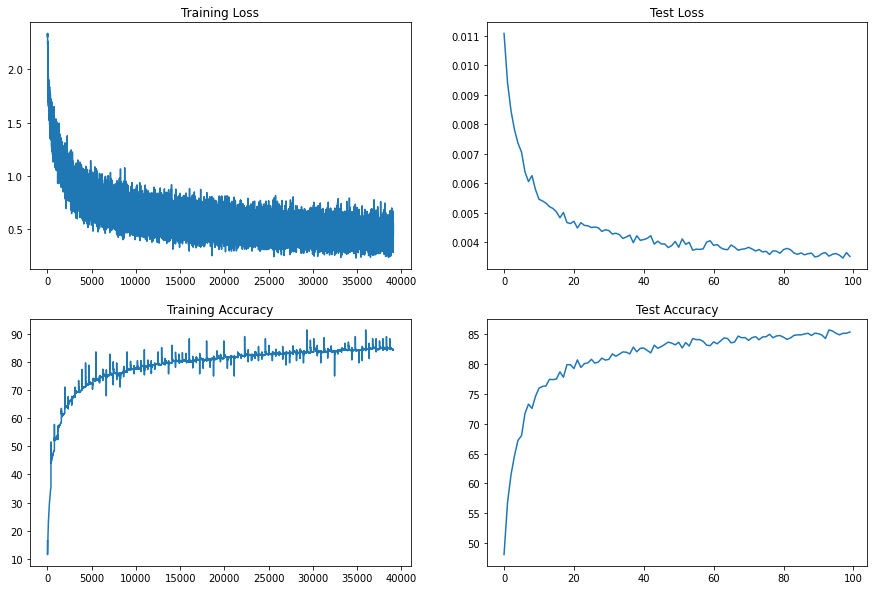

In [19]:
visualization.plot_acc_loss(train_losses, train_acc, test_losses, test_acc)

## Misclassified Images

Files already downloaded and verified


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]

cuda



/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/model/cifar10_model.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/utils/visualization.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_norm = torch.tensor(mean).reshape(1, 3, 1, 1)
/content/drive/MyDrive/Colab Notebooks/EVA_6/S7_Advanced/src/utils/visualization.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_norm = torch.tensor(std).reshape(1, 3, 1, 1)


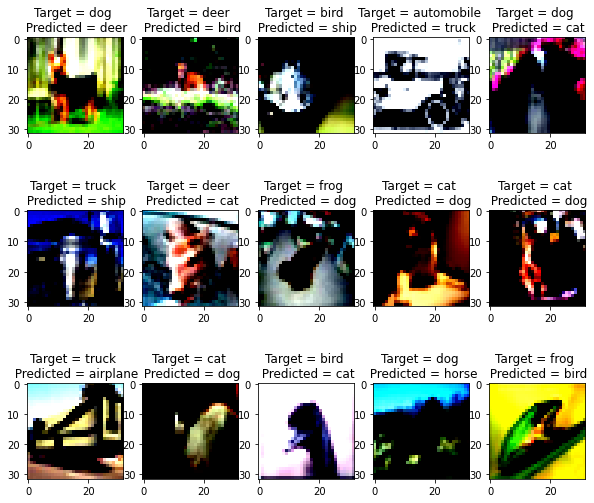

In [20]:
visualization.misclassified_images(model, trainset.classes, test_transform, trainset, testset, batch_size )